# Two dipoles

In this notebook we test the inversion of the magnetic signal of two dipole sources with volumes equivalent to cuboid particles. The magnetic sources are aligned vertically. The source at the top has a larger volume. The magnetic signal is defined at the sensors of a scanning surface with specific dimensions. A diagram of the system looks like:

<img src="figures/two_dip_diagram.png" width=300>

In this problem the magnetic signal of the large-volume dipole source obscures the magnetic signal of the source at the bottom, and leads to an ill-conditioned forward matrix. We will study how the error in the magnetization solution grows as the bottom dipole source is moved farther away from the other source.

In [1]:
import numpy as np
import mmt_dipole_cuboid_inversion as dci
from pathlib import Path
from collections import namedtuple
import matplotlib.pyplot as plt
plt.style.use('adornmyplot.mplstyle')
import scipy.optimize as so  # so.curve_fit

## Inversion

Load the data and perform the inversion for every separation value of the positions of the dipoles. We load the data generated by the `generate_two_dipoles.py` script.

In [2]:
dataDir = Path("./two_dipoles_sep_data")

In [3]:
# Here we define a data container using a namedtuple
Mdata = namedtuple('Mdata', 'M Merr1 Merr2 AngleErr1 AngleErr2 sep BzInv Bz cond_num')
M_sols = []

Ms = 4.8e5
datadir = Path('two_dipoles_sep_data/')
# We make multiple inversions by increasing the distance of the bottom cube
for dipole_sep in range(5, 81, 5):

    scanfile = datadir / f'two_dipoles_sep_{dipole_sep:02d}_Bzgrid.txt'
    cuboidfile = datadir / f'two_dipoles_sep_{dipole_sep:02d}_cuboids.txt'
    
    sensor_domain = np.array([[0, 0], [100., 100.]]) * 1e-6
    scan_spacing = 2e-6
    scan_deltax = 1e-6
    scan_deltay = 1e-6
    scan_area = 4e-12
    scan_height = 2e-6

    dip_inversion = dci.DipoleCuboidInversion(sensor_center_domain=sensor_domain, 
                                              scan_spacing=scan_spacing, 
                                              scan_deltax=scan_deltax, scan_deltay=scan_deltay, 
                                              scan_area=scan_area, scan_height=scan_height,
                                              verbose=False)

    dip_inversion.read_files(scanfile, cuboidfile, cuboid_scaling_factor=1e-6)
    dip_inversion.set_scan_domain(gen_sd_mesh_from='sensor_center_domain')
    dip_inversion.prepare_matrix(method='cython')
    dip_inversion.calculate_inverse(method='scipy_pinv', rcond=1e-30)

    # Check relative error is less than 1% = 0.01
    # assert abs(dip_inversion.Mag[1] - Ms) / Ms < 1e-2
    
    m1_sol = np.array([[0., 1., 1.]]) / np.sqrt(2.)
    m2_sol = np.array([[-1., -1., 0.]]) / np.sqrt(2.)
    msol = np.row_stack((m1_sol, m2_sol))
    
    m = dip_inversion.Mag.reshape(-1, 3)
    # print(np.linalg.norm(m, axis=1))
    minv = m / np.linalg.norm(m, axis=1)[:, np.newaxis]
    angleErr = np.arccos(np.sum(msol * minv, axis=1))

    Merr1 = np.abs(np.linalg.norm(dip_inversion.Mag[:3]) - Ms) / Ms
    Merr2 = np.abs(np.linalg.norm(dip_inversion.Mag[3:6]) - Ms) / Ms

    cnum = np.linalg.cond(dip_inversion.Forward_G, p=2)
    
    M_sols.append(Mdata(M=dip_inversion.Mag, Merr1=Merr1, Merr2=Merr2,
                        AngleErr1=angleErr[0], AngleErr2=angleErr[1],
                        sep=float(dipole_sep),
                        BzInv=dip_inversion.forward_field(),
                        Bz=dip_inversion.scan_matrix,
                        cond_num=cnum))
    
    print(f'Dipole sep : {dipole_sep:>2}   κ(Φ_flux) = {cnum:>7.2f}')

Dipole sep :  5   κ(Φ_flux) =   68.02
Dipole sep : 10   κ(Φ_flux) =   69.75
Dipole sep : 15   κ(Φ_flux) =   84.90
Dipole sep : 20   κ(Φ_flux) =  107.17
Dipole sep : 25   κ(Φ_flux) =  136.03
Dipole sep : 30   κ(Φ_flux) =  172.01
Dipole sep : 35   κ(Φ_flux) =  216.08
Dipole sep : 40   κ(Φ_flux) =  269.45
Dipole sep : 45   κ(Φ_flux) =  333.52
Dipole sep : 50   κ(Φ_flux) =  409.87
Dipole sep : 55   κ(Φ_flux) =  500.21
Dipole sep : 60   κ(Φ_flux) =  606.40
Dipole sep : 65   κ(Φ_flux) =  730.46
Dipole sep : 70   κ(Φ_flux) =  874.53
Dipole sep : 75   κ(Φ_flux) = 1040.91
Dipole sep : 80   κ(Φ_flux) = 1232.04


We can plot the condition number as a function of separation of the bottom cuboid. For this we also find an exponential fir to the curve:

In [4]:
xc = np.array([m.sep for m in M_sols])
yc = np.array([m.cond_num for m in M_sols])

# Find the xponential fit:
fit_cond = lambda x, a, b, c: a * np.exp(b * x + c * x ** 2)
pcond, pccond = so.curve_fit(fit_cond, xc[:], yc[:], p0=[0, -0.1, -0.001])

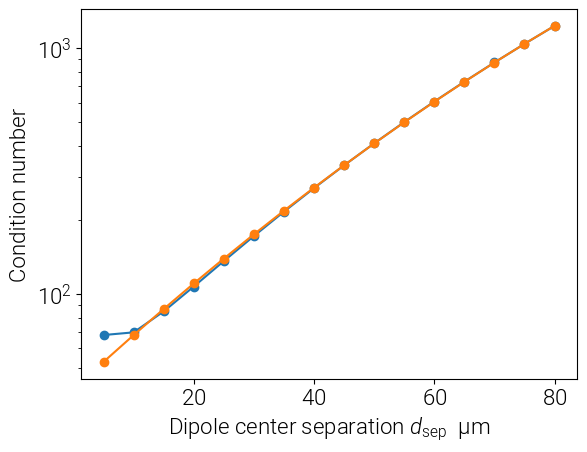

In [5]:
f, ax = plt.subplots()
ax.plot(xc, yc, 'o-')
ax.plot(xc, fit_cond(xc, *pcond), 'o-')
ax.set_yscale('log')
ax.set_ylabel('Condition number')
ax.set_xlabel('Dipole center separation ' + r'$d_{\mathrm{sep}}$' +'  µm')
plt.show()

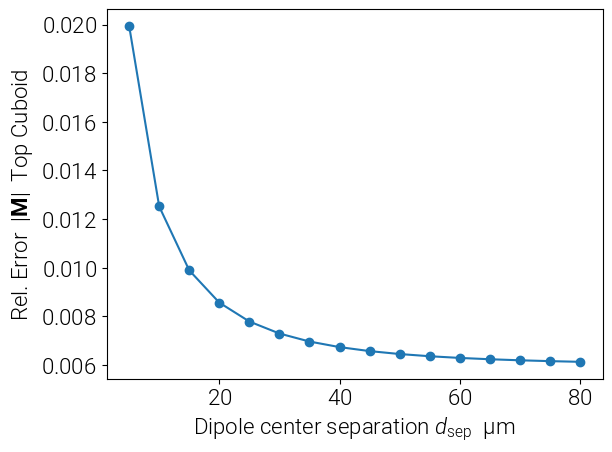

In [6]:
f, ax = plt.subplots()
x = np.array([m.sep for m in M_sols])
y1 = np.array([m.Merr1 for m in M_sols])
y2 = np.array([m.Merr2 for m in M_sols])
ax.plot(x, y1, 'o-')
# ax.plot(x, y2, 'o-')
# plt.yscale('log')
ax.set_ylabel('Rel. Error  ' + r'$|\mathbf{M}|$' + '  Top Cuboid')
ax.set_xlabel('Dipole center separation ' + r'$d_{\mathrm{sep}}$' +'  µm')
plt.show()

In [7]:
# calculate polynomial for the fit 
fit_f_dip1 = lambda x, a, b, c: a * np.exp(b * x) + c
p, pc = so.curve_fit(fit_f_dip1, x[1:], y1[1:], p0=[0, -0.1, -0.01])

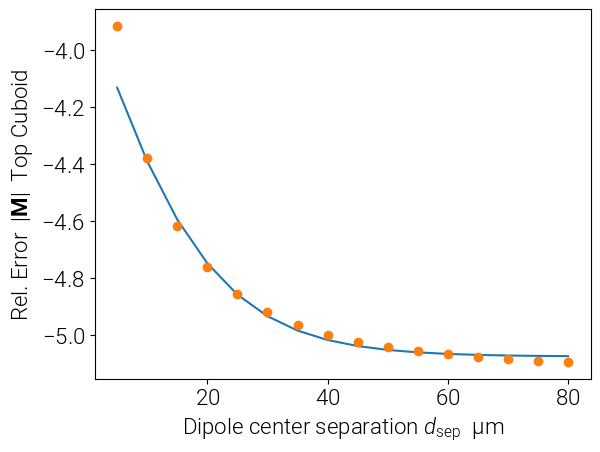

In [8]:
f, ax = plt.subplots()
plt.plot(x, np.log(fit_f_dip1(x, *p)))
plt.plot(x, np.log(y1), 'o')
ax.set_ylabel('Rel. Error  ' + r'$|\mathbf{M}|$' + '  Top Cuboid')
ax.set_xlabel('Dipole center separation ' + r'$d_{\mathrm{sep}}$' +'  µm')
plt.show()

In [9]:
print('Rel Error of 1 at x = 10 µm: ', y1[np.where(x == 10)])

Rel Error of 1 at x = 10 µm:  [0.01251662]


In [10]:
print('Rel Error of 2 at x = 10 µm: ', y2[np.where(x == 10)])

Rel Error of 2 at x = 10 µm:  [0.1245201]


In [11]:
def fit_f_dip2(x, a, b):
    return a * np.exp(b * x)

In [12]:
popt, pcov = so.curve_fit(fit_f_dip2, x, y2, p0=[0, 0.1])

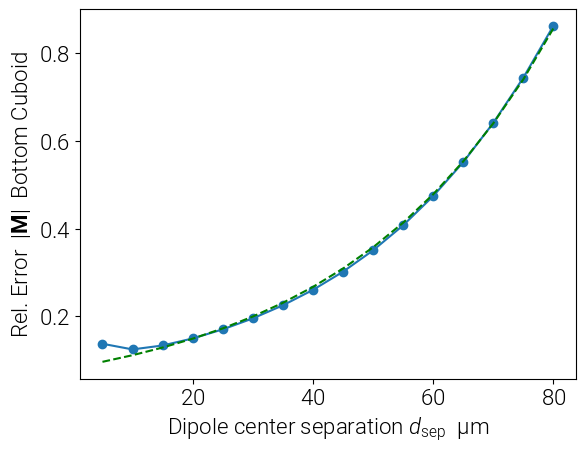

In [13]:
f, ax = plt.subplots()
plt.plot(x, y2, 'o-')
plt.plot(x, fit_f_dip2(x, *popt), 'g--',
         label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
ax.set_ylabel('Rel. Error  ' + r'$|\mathbf{M}|$' + '  Bottom Cuboid')
ax.set_xlabel('Dipole center separation ' + r'$d_{\mathrm{sep}}$' +'  µm')
plt.show()

In [14]:
diag = plt.imread('./figures/two_dip_diagram.png')

In [15]:
x = np.array([m.sep for m in M_sols])
y1 = np.array([m.Merr1 for m in M_sols])
y2 = np.array([m.Merr2 for m in M_sols])

In [16]:
print('Generating and saving plot for relative errors of the magnetization for bottom and top cuboids:')

Generating and saving plot for relative errors of the magnetization for bottom and top cuboids:


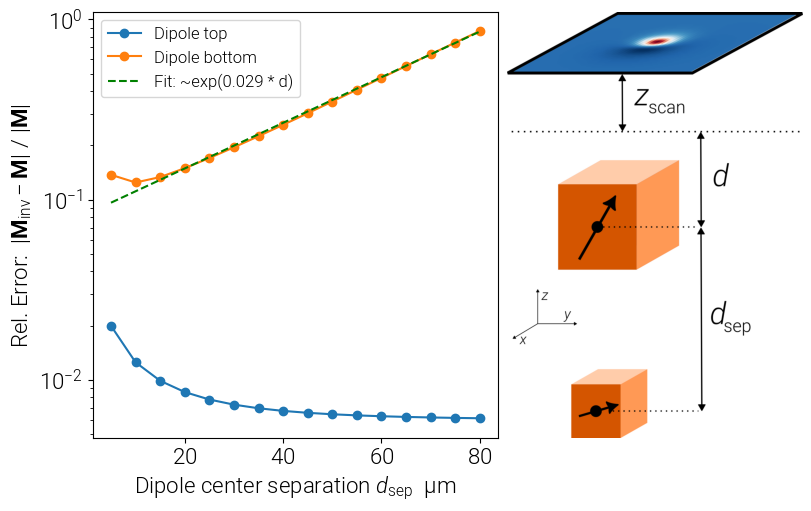

In [17]:
f, axs = plt.subplots(ncols=2, figsize=(8, 5), width_ratios=(0.55, 0.4),
                      constrained_layout=True
                      )
ax = axs[0]
ax.plot(x, y1, 'o-', label='Dipole top')
ax.plot(x, y2, 'o-', label='Dipole bottom')
ax.plot(x, fit_f_dip2(x, *popt), 'g--',
        label=f'Fit: ~exp({popt[1]:.3f} * d)')
ax.set_yscale('log')
ax.legend()
ax.set_ylabel('Rel. Error:  ' + r'$|\mathbf{M}_{\mathrm{inv}} - \mathbf{M}| \,\, / \,\, |\mathbf{M}|$')
ax.set_xlabel('Dipole center separation ' + r'$d_{\mathrm{sep}}$' +'  µm')

ax = axs[1]
ax.set_axis_off()
ax.imshow(diag, aspect='auto')

plt.savefig('figures/two_dipoles_relError_diagram.pdf', bbox_inches='tight', dpi=200)
plt.show()

In [18]:
print('Plotting Bz inverted and residuals:')

Plotting Bz inverted and residuals:


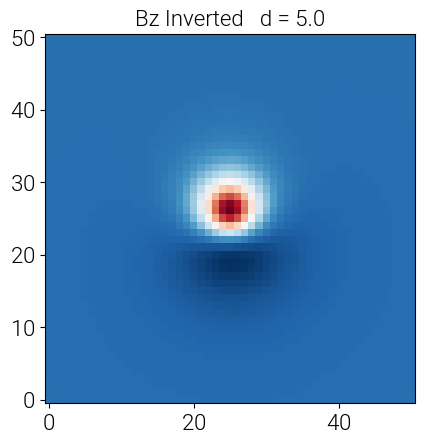

In [19]:
m = M_sols[0]
f, ax = plt.subplots()
ax.imshow(m.BzInv, origin='lower', cmap='RdBu_r')
ax.set_title(f'Bz Inverted   d = {m.sep}')
plt.savefig('figures/two_dip_signal.svg')
plt.show()

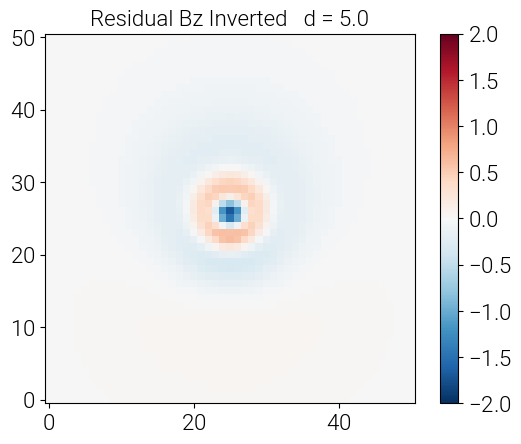

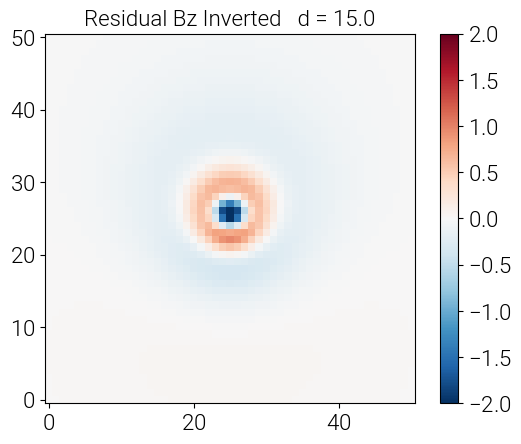

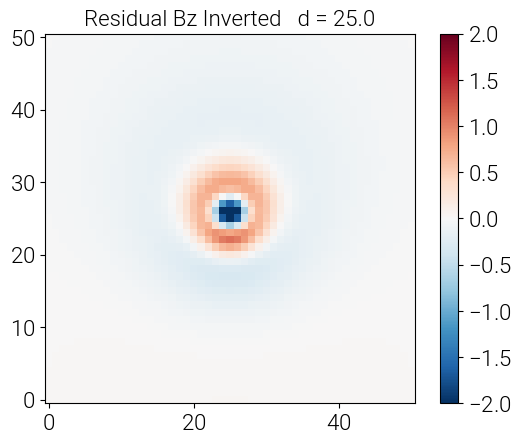

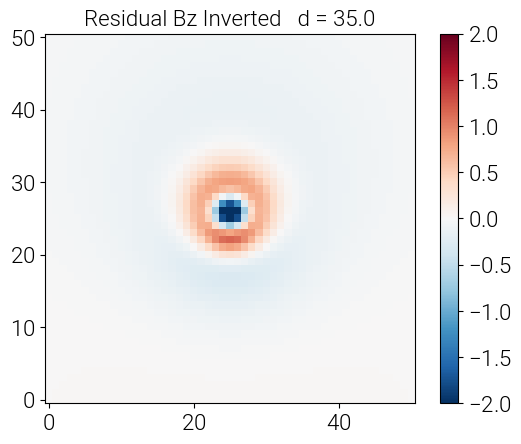

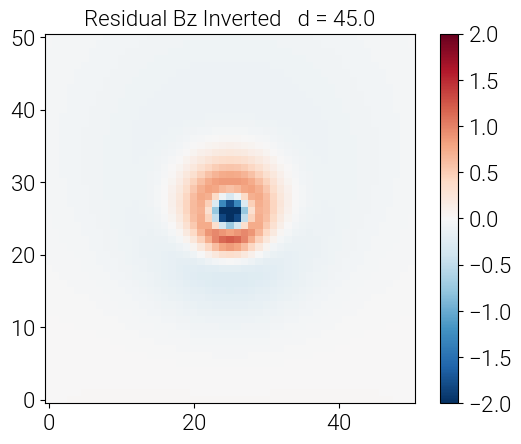

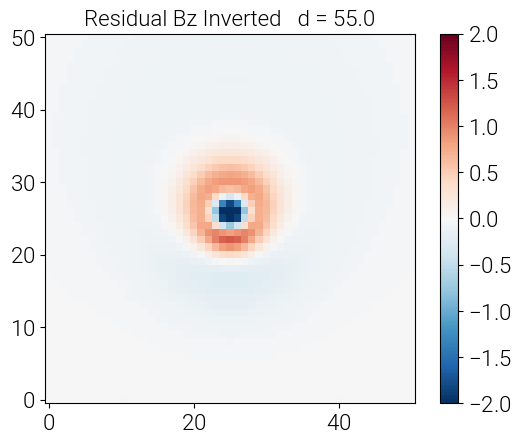

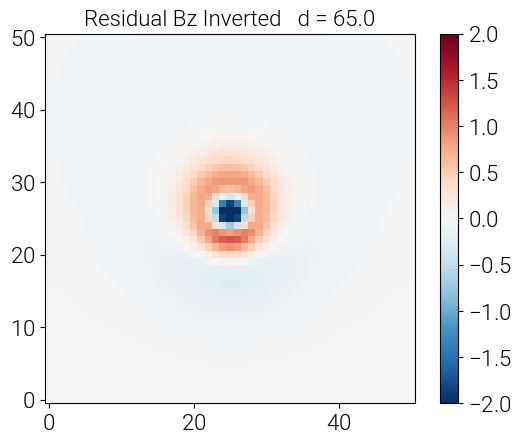

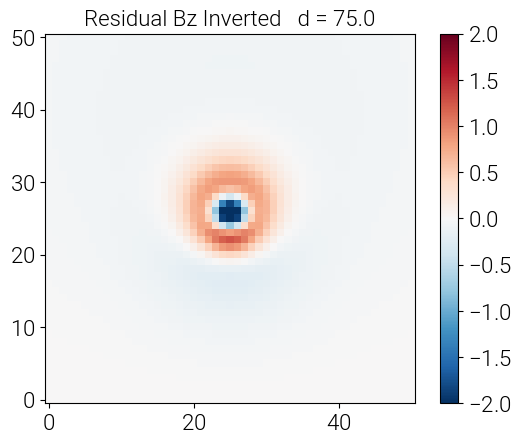

In [20]:
for m in M_sols[::2]:
    f, ax = plt.subplots()
    scan_area = 4e-12
    res = m.BzInv - (m.Bz / scan_area)
    im = ax.imshow(res * 1e6, origin='lower', cmap='RdBu_r', vmin=-2, vmax=2)
    plt.colorbar(im)
    ax.set_title(f'Residual Bz Inverted   d = {m.sep}')
    plt.show()